In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2
import shutil
import time
from sklearn.metrics import classification_report

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
train_csv = "/kaggle/input/butterfly-image-classification/Training_set.csv"
train_folder = "/kaggle/input/butterfly-image-classification/train/"

test_csv = "/kaggle/input/butterfly-image-classification/Testing_set.csv"
test_folder = "/kaggle/input/butterfly-image-classification/test/"

result_path = f"/kaggle/working/run/"
os.makedirs(result_path, exist_ok=True)

checkpoint_path = os.path.join(result_path, "best_model.h5")
loss_image_path = os.path.join(result_path, 'validation loss.png')
acc_image_path = os.path.join(result_path, 'validation accuracy.png')
confusion_image_path = os.path.join(result_path, 'confusion matrix.png')

In [3]:
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

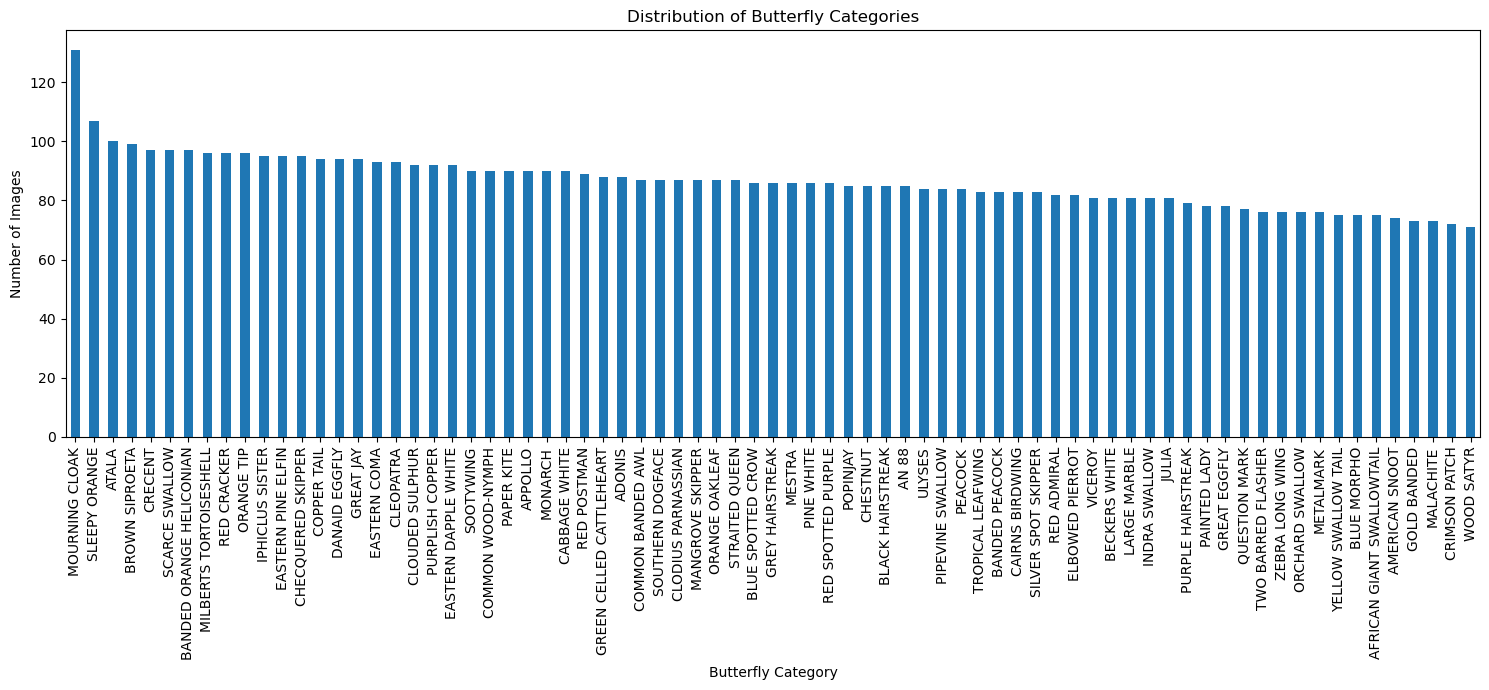

In [4]:
plt.figure(figsize=(15, 7))
train_df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Butterfly Categories')
plt.xlabel('Butterfly Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [5]:
image_size = (150, 150)
batch_size = 32
epochs = 100
learning_rate = 0.0001


class_name = list(set(train_df['label']))
print(class_name)

['CHECQUERED SKIPPER', 'ADONIS', 'BLUE MORPHO', 'SOUTHERN DOGFACE', 'STRAITED QUEEN', 'MESTRA', 'POPINJAY', 'MALACHITE', 'CLODIUS PARNASSIAN', 'SOOTYWING', 'LARGE MARBLE', 'QUESTION MARK', 'CLOUDED SULPHUR', 'COPPER TAIL', 'BECKERS WHITE', 'JULIA', 'RED CRACKER', 'INDRA SWALLOW', 'AN 88', 'METALMARK', 'SLEEPY ORANGE', 'RED SPOTTED PURPLE', 'PURPLE HAIRSTREAK', 'RED ADMIRAL', 'AMERICAN SNOOT', 'ELBOWED PIERROT', 'MOURNING CLOAK', 'BROWN SIPROETA', 'GREAT JAY', 'CRECENT', 'AFRICAN GIANT SWALLOWTAIL', 'VICEROY', 'PEACOCK', 'ATALA', 'DANAID EGGFLY', 'SILVER SPOT SKIPPER', 'ORCHARD SWALLOW', 'GREY HAIRSTREAK', 'GREEN CELLED CATTLEHEART', 'PAINTED LADY', 'IPHICLUS SISTER', 'CLEOPATRA', 'BANDED PEACOCK', 'EASTERN COMA', 'EASTERN PINE ELFIN', 'COMMON WOOD-NYMPH', 'RED POSTMAN', 'CRIMSON PATCH', 'ULYSES', 'ZEBRA LONG WING', 'ORANGE OAKLEAF', 'PAPER KITE', 'BLUE SPOTTED CROW', 'BLACK HAIRSTREAK', 'GOLD BANDED', 'YELLOW SWALLOW TAIL', 'TWO BARRED FLASHER', 'CHESTNUT', 'PINE WHITE', 'CABBAGE WHITE

In [6]:
features = []
labels = []

for image in tqdm(os.listdir(train_folder), desc="Preprocess Image") :
    label_name = train_df.loc[train_df['filename'] == image, 'label'].values[0]
    label = class_name.index(label_name)
    image_read = cv2.imread(os.path.join(train_folder, image))
    image_resized = cv2.resize(image_read, image_size)
    image_normalized = image_resized / 255.0
    features.append(image_normalized)
    labels.append(label)

Preprocess Image: 100%|██████████| 6499/6499 [00:55<00:00, 117.40it/s]


In [7]:
print(len(features))
print(len(labels))

features = np.asarray(features)
labels = np.asarray(labels)

6499
6499


In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, shuffle=True, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=42)

In [9]:
del features
del labels

In [10]:
base_model = ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape=(image_size[0], image_size[1], 3),
)

num_layers_to_train = int(np.ceil(0.2 * len(base_model.layers)))

for layer in base_model.layers[:num_layers_to_train] :
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
predictions = Dense(75, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization

In [11]:
model.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)

start_time = time.time()

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data = (X_valid,y_valid),
    callbacks=[model_checkpoint, early_stopping],
    batch_size = batch_size,
)

end_time = time.time()

Epoch 1/100
143/143 [==============================] - 57s 131ms/step - loss: 7.1987 - accuracy: 0.3748 - val_loss: 8.6437 - val_accuracy: 0.0410
Epoch 2/100
143/143 [==============================] - 15s 104ms/step - loss: 4.2627 - accuracy: 0.8191 - val_loss: 6.8226 - val_accuracy: 0.2656
Epoch 3/100
143/143 [==============================] - 15s 105ms/step - loss: 3.1067 - accuracy: 0.9492 - val_loss: 4.6318 - val_accuracy: 0.5651
Epoch 4/100
143/143 [==============================] - 15s 105ms/step - loss: 2.4720 - accuracy: 0.9776 - val_loss: 3.5635 - val_accuracy: 0.7046
Epoch 5/100
143/143 [==============================] - 15s 105ms/step - loss: 2.0351 - accuracy: 0.9870 - val_loss: 2.8824 - val_accuracy: 0.7528
Epoch 6/100
143/143 [==============================] - 15s 102ms/step - loss: 1.7062 - accuracy: 0.9872 - val_loss: 2.5382 - val_accuracy: 0.7497
Epoch 7/100
143/143 [==============================] - 15s 104ms/step - loss: 1.4061 - accuracy: 0.9943 - val_loss: 2.2502 -

In [12]:
print("Training Time", end_time - start_time)

Training Time 608.5670804977417


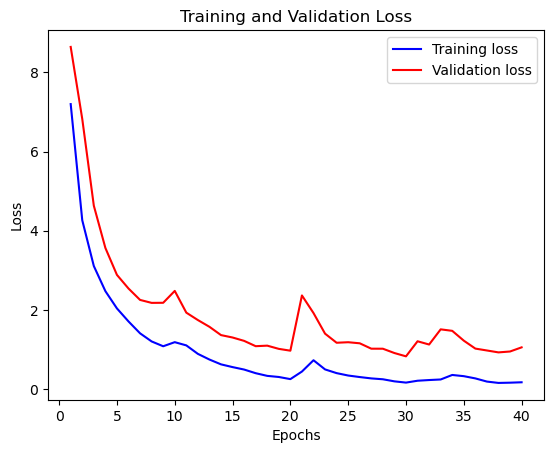

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(loss_image_path)
plt.show()

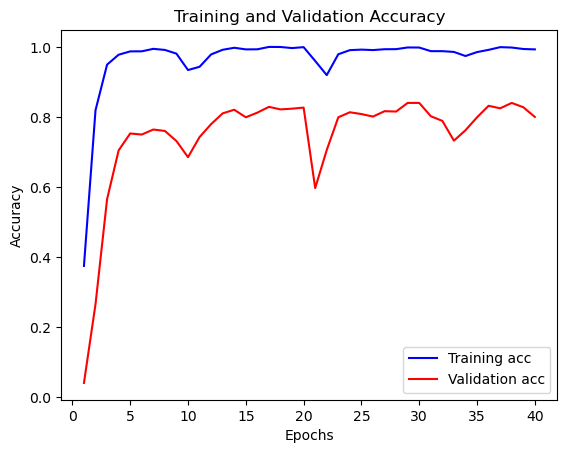

In [14]:
acc = history.history['accuracy']

val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(acc_image_path)
plt.show()

In [15]:
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)

classification_rep = classification_report(y_test, y_pred, target_names=class_name, digits=4)
print("Classification Report:\n", classification_rep)

classification_file = 'classification_report.txt'
with open(classification_file, 'w') as file:
    file.write(classification_rep)

31/31 [==============================] - 2s 31ms/step
Classification Report:
                            precision    recall  f1-score   support

       CHECQUERED SKIPPER     1.0000    0.6667    0.8000        15
                   ADONIS     0.8000    0.8889    0.8421         9
              BLUE MORPHO     0.9000    0.7500    0.8182        12
         SOUTHERN DOGFACE     0.6667    0.7273    0.6957        11
           STRAITED QUEEN     0.8000    0.8000    0.8000        10
                   MESTRA     0.4545    1.0000    0.6250        10
                 POPINJAY     1.0000    0.8333    0.9091        12
                MALACHITE     0.8750    0.8750    0.8750         8
       CLODIUS PARNASSIAN     0.5385    0.7778    0.6364         9
                SOOTYWING     0.7692    0.7692    0.7692        13
             LARGE MARBLE     1.0000    0.4167    0.5882        12
            QUESTION MARK     1.0000    0.4667    0.6364        15
          CLOUDED SULPHUR     0.5625    0.5294    